# Analyze Model

How well does our trained model perform on unseen data? 

In [135]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
from scipy import stats

import os

import pickle as pkl 

# Loss Curve Analysis

Load the (directory of) losses

In [11]:
loss_dir = 'March 21st'
loss_files = os.listdir(f'loss/{loss_dir}')

Load each loss curve, also keeping track of the particular instance

In [9]:
losses = {}
for loss in loss_files:
    with open(f'loss/{loss_dir}/{loss}', 'rb') as f:
        temp = pd.read_csv(f)
    losses[loss] = temp

Store the validation loss to quantify performance ... which one did the best? 

In [10]:
train_mse = {}
test_mse = {}

for loss in loss_files:

    train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
    test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))

# What is the 'best performing' model?
    

C:\Users\tjaou104\AppData\Local\Temp\ipykernel_23288\2128013759.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
C:\Users\tjaou104\AppData\Local\Temp\ipykernel_23288\2128013759.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))


In [11]:
train_mse

{'loss_train10.csv': 0.0009672867123782904,
 'loss_train11.csv': 0.0010146919944519894,
 'loss_train2.csv': 0.018865187211406093,
 'loss_train3.csv': 0.0018220415785729107,
 'loss_train4.csv': 0.0006915964099404769,
 'loss_train5.csv': 0.001788816450984078,
 'loss_train6.csv': 0.0003449582139370178,
 'loss_train7.csv': 0.0015906634363076712,
 'loss_train8.csv': 0.0009987704586661614,
 'loss_train9.csv': 0.0008864350187936729}

Factoring in the Feburary 28 loss curves, this takes into account the variables 'solar_radiation', 'temperature', 'CN^2', 'Relative Humidity' ... maybe make a scatter plot? 

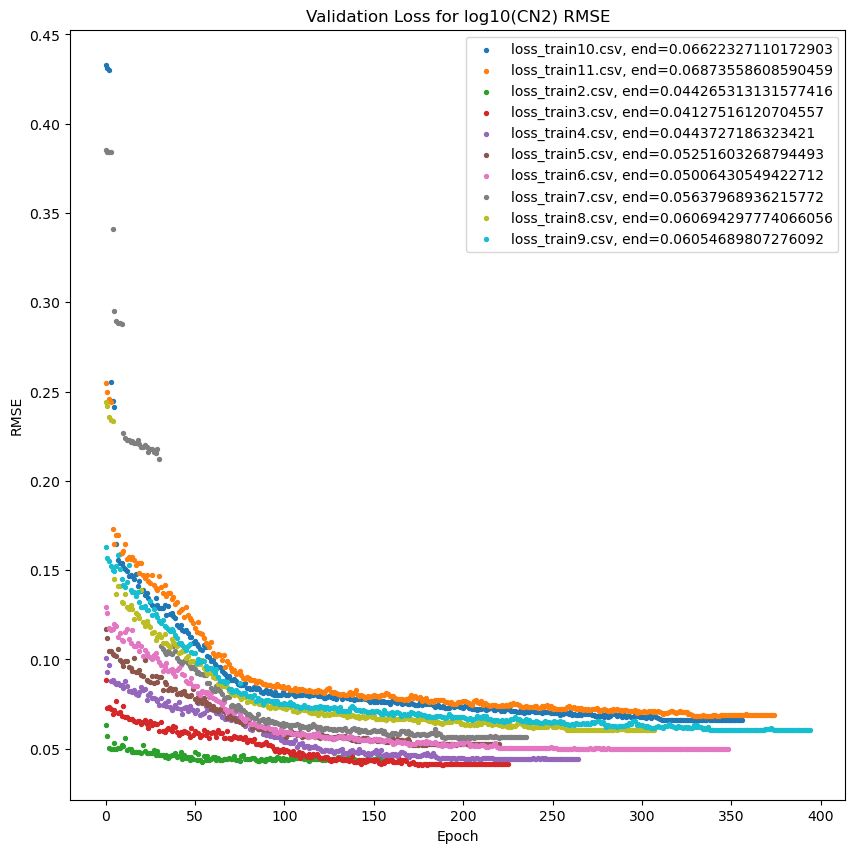

In [12]:
plt.figure(figsize=(10,10))
for ii, loss in enumerate(loss_files):
    y = np.sqrt(losses[loss]['val_loss'][:])
    epochs = np.arange(len(y))
    plt.scatter(epochs, y, s=8, label=f'{loss}, end={test_mse[loss]}')
    
plt.title('Validation Loss for log10(CN2) RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

Make a line plot similar to the paper

In [7]:
num_of_hours = [1,2,3,4,6,12]
tester_mse = [test_mse['loss_oneHour_7006.csv'], test_mse['loss_twoHour_3484.csv'],test_mse['loss_threeHour_6371.csv'], test_mse['loss_fourHour_7641.csv'], test_mse['loss_sixHour_1152.csv'], test_mse['loss_twelveHour_1654.csv']]  
plt.plot(num_of_hours, tester_mse, marker='o')

plt.xlabel('Number of Hours Ahead')
plt.ylabel('Validation RMSE on Log10(CN2)')

KeyError: 'loss_oneHour_7006.csv'

In [25]:
test_mse['loss_oneHour_7006.csv']

TypeError: list indices must be integers or slices, not str

# Testing Model Predictions

Choose input features

In [130]:
input_features = ['relative_humidity', 'solar_radiation', 'CN2', 'temperature', 'day', 'time']

Load the data

In [132]:
from augmentation import jitter, window_slice, window_warp

difference = -1

# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    minX = np.min(x[np.nonzero(x)])
    maxX = np.max(x[np.nonzero(x)])
    
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data_select(x, minX, maxX):  
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    return x*unnorm_fac + minX
    
# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll

def hours_to_int(x):
    if x[0:-2]=='':
        return 0
    else:
        return int(x[0:-2])
    
def convert_to_sec(minute, hour):
    return 3600*hour + 60*minute


def load_data(direc_name, time_steps, input_list, window_size, num_of_examples, minOut_X, maxOut_X, full_time_series=False, pad_output_zeros = True,  forecast_len=1, time_res=1, start_index=0):

    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    num_features = len(input_list)
    # If we are including the day and time, add an extra to factor in the cos and sin components. 
    if ('day' in input_list):
        num_features+= 1
    if ('time' in input_list):
        num_features+= 1
        
    print(f'Parameter List: {input_list}')
    
    num_of_zeros = 0
    
    
    for jj, name in enumerate(directory_list, start=start_index):
        
        df = pd.read_csv(f'{direc_name}/{name}')
        #print(name)
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation', 'hr:min (UTC)':'time', 'Julian day (UTC)': 'day'})
        # Map the day into a unit circle, and create 'day_sin'  and 'day_cos' to define the x and y components in the circle. 
        df['day_sin'] = np.sin(df['day']*(2.*np.pi/365))
        df['day_cos'] = np.cos(df['day']*(2.*np.pi/365))
        # For time, we convert to string representation
        df['time']=df['time'].astype(str)
        df['minute'] = df['time'].apply(lambda x: int(x[-2:]))
        df['hour'] = df['time'].apply(lambda x: hours_to_int(x))
        df['second'] = convert_to_sec(df['minute'], df['hour'])
        # Map the time into a unit circle 
        df['time_sin']= np.sin(df['second']*(2.*np.pi/86400))
        df['time_cos']=np.cos(df['second']*(2.*np.pi/86400))
        
        #print(df.columns)
        #input()
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
            #print(jj)
            num_of_zeros += 1
            print(f'number of zeros: {num_of_zeros}')
            print('error data detected. Skipping to next value')
            continue
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((output_len, 1))
        
        ###### INPUT DATA #######
        
        for ii, colName in enumerate(input_list):
            if(colName=='day'):
                # include both day_sin and day_cos
                dataset_weather[:,ii] = df['day_sin'].to_numpy()
                dataset_weather[:,ii+1] = df['day_cos'].to_numpy()
            if(colName=='time'):
                # Include both time_sin and time_cos
                dataset_weather[:,ii] = df['time_sin'].to_numpy()
                dataset_weather[:,ii+1] = df['time_cos'].to_numpy()
            if(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:
                dataset_weather[:,ii] = df[colName].to_numpy()
                
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        
        # First, let's consider every example up to forecast length 
        nn_output  = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        
        # Next, only consider every time_res example in the final output
        dataset_output[:,0] = nn_output[np.mod(np.arange(len(nn_output)),time_res) == 0]
        
        # Let's consider wildly varying output data. Compute the difference between maximum and minimum. 
        max_CN2 = np.max(np.abs(dataset_output[:,0]))
        min_CN2 = np.min(np.abs(dataset_output[:,0]))
        
        diff = np.abs(max_CN2 - min_CN2)
        
        if (diff >= -1):
            total_input.append(dataset_weather)
            total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
            
        if (jj-start_index>num_of_examples):
            print("Finished loading data!")
            break;
                
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply rolling average onto the input data
    total_input = rollify_training(total_input, window_size)
    
    
    # Apply normalization to each input entry (except for CN2, this needs to be handled specially)
    for ii in np.delete(np.arange(len(input_list)), 2):
        print(ii)
        #total_input[:,:,ii], minOut,maxOut = norm_data(total_input[:,:,ii])
        #print(minOut)
        #print(maxOut)
        total_input[:,:,ii],_,_ = norm_data_select(total_input[:,:,ii], minOut_X[ii], maxOut_X[ii])

    # If we are working with time series prediction, apply rolling on output time series
    
    if (full_time_series):
        total_output = rollify_training(total_output, window_size)
    
    # Finally, if we're working with a time series, let's pad out the output array with 0s
    
    window_time_steps_input = total_input.shape[1]
    window_time_steps_output = total_output.shape[1]
    dataset_len = int(total_input.shape[0])

    total_output_padded = np.zeros((total_input.shape[0], window_time_steps_input, 1))

    total_output_padded[:,:window_time_steps_output, 0] = total_output[:,:,0]

    # At this point, normalize the CN2 for BOTH input and output. This is important!
    
    ziggy = np.concatenate((total_input[:,:,2], total_output_padded[:,:,0]))
    ziggy,_,_ = norm_data_select(ziggy, minOut_X[2], maxOut_X[2])

    total_input[0:dataset_len,:,2] = ziggy[0:dataset_len, :]
    total_output_padded[0:dataset_len,:,0] = ziggy[dataset_len::,:]
    
    if(full_time_series):
        if (pad_output_zeros==False):
            total_output[:,:,0] = total_output_padded[:,0:output_len,0]
            return total_input, total_output, minOut, maxOut
        return total_input, total_output_padded, minOut, maxOut 
    else:
        return total_input, total_output_padded[:,0], minOut, maxOut
    
    



# NEW: Load the model & test data 

Compute time resolution

In [136]:
time_res = 15
forecast_len = 720
output_len = int(forecast_len/time_res)

Load da model 

In [137]:
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8

fifteenMinutes_6HourForecast = 'trainSeries_15MinInput_6Hour_9487'
fifteenMinutes_12HourForecast = 'trainSeries_15MinInput_12Hour_8893'

curr_model = fifteenMinutes_12HourForecast

# Load the models

loaded_model_1 = tf.keras.models.load_model(f'models/{curr_model}', custom_objects={'mse_mod':mse_mod})

fifthteenMin_timeRes = 'trainSeries_15MinRes_8254'

# Load the test data 

with open(f'Test Data/{curr_model}_testData.pkl', 'rb') as f:
    X_test, y_test = pkl.load(f)


In [3]:
with open(f'Test Data/trainSeries_15MinInput_6Hour_fullNorm_5621_testData.pkl', 'rb') as f:
    X_test, y_test = pkl.load(f)

# OLD: Load data based on old train-test splitting paradigm

In [134]:
time_len = 720
time_res = 1
forecast_len = 720
output_len = int(forecast_len/time_res)

direc_name = f"Batched Data/OneMinResolution_OneHourWindow" # yaml worthy
start_index =  36000

# For consistency, normalize the data wrt training. 

# minOut_X = [25.47199, -0.3995518, -16.51427857351842 ,-18.04353]
# maxOut_X = [99.52488, 72.58526,-13.709965388637482 ,32.07004]


minOut_X = [16.29781, -0.3995518, -16.46344155742847,  -18.04353]
maxOut_X = [99.52488, 71.5599, -13.749579997691106,  32.07004]


#print(f"Number of files:{sizeOfFiles}")
train_factor = 0.50
val_factor = 0.15
# (direc_name, time_steps, input_list, window_size, num_of_examples, full_time_series=False, forecast_len=1):
X, y, minOut, maxOut = load_data(direc_name, time_len, input_features, 1, 2000, minOut_X, maxOut_X, full_time_series=True, pad_output_zeros=False, forecast_len=forecast_len, time_res=time_res, start_index=start_index)
num_of_examples = int(len(X)*train_factor)
X_train, y_train = X[0:num_of_examples], y[0:num_of_examples]
X_test, y_test = X[num_of_examples::], y[num_of_examples::]

Parameter List: ['relative_humidity', 'solar_radiation', 'CN2', 'temperature', 'day', 'time']
Data loaded:36000
Data loaded:36500
Data loaded:37000
Data loaded:37500
Data loaded:38000
Finished loading data!
0
1
3
4


IndexError: list index out of range

In [203]:
len(X_test)

414

X_train

# Load trained model

Let's start with the static prediction ones

In [ ]:

# Static prediction models 

static_direc = 'Static Time Prediction/'


static_1 = static_direc + 'trainStatic1_1682'
static_2 = static_direc + 'trainStatic2_6543'
static_3 = static_direc + 'trainStatic3_8010'
static_4 = static_direc + 'trainStatic4_9970'
static_5 = static_direc + 'trainStatic5_2533'
static_6 = static_direc + 'trainStatic6_7528'
static_7 = static_direc + 'trainStatic7_3682'
static_8 = static_direc + 'trainStatic8_3620'
static_9 = static_direc + 'trainStatic9_2710'
static_10 = static_direc + 'trainStatic10_2452'
static_11 = static_direc + 'trainStatic11_9227'
static_12 = static_direc + 'trainStatic12_3873'



static_direcs = [static_1, static_2, static_3, static_4, static_5, static_6, static_7, static_8, static_9, static_10, static_11, static_12]
loaded_models = []

for static_model in static_direcs:
    loaded_models.append()
    


Time series predictions 

In [4]:

# Model directories

# Week of March 4th Models

vinso_12_2 = 'timeSeries12_320Neurons_3Window_1310'
vinso_12 = 'timeSeries12_wider_5518'
vinso_9 = 'timeSeries9_4975'
vinso_6 = 'timeSeries6_8843'
vinso_3 = 'timeSeries3_4870'


# March 12th models

singleShot_12 = 'timeSeries12_singleShot_base_6691'
singleShot_9 = 'timeSeries9_singleShot_1319'
singleShot_6 = 'timeSeries6_singleShot_7836'
singleShot_biDirec = 'timeSeries12_base_bidirec_2662'

# March 18th Models

jitter = 'train12_jitter_6858'
windowSlice = 'train12_window_slice_3733'
windowWarp = 'train12_windowwarp_3911'
oneWindow = 'timeSeries12_base_oneWindow_5550'

# Feature Engineered Models

diff_11 = "train_diff_11_8528"
diff_13 = "train_diff_13_2342"

# Varying forecast models

train_2 = 'TrainSeries2_4244'
train_3 = 'TrainSeries3_7021'
train_4 = 'TrainSeries4_3986'
train_5 = 'trainSeries5_6144'
train_6 = 'trainSeries6_8141'
train_7 = 'trainSeries7_3798'
train_8 = 'trainSeries8_5771'
train_9 = 'trainSeries9_7705'
train_10 = 'trainSeries10_3605'
train_11 = 'trainSeries11_3402'

# 4 Hour predictions using the latest normalization technology 

train_4_new = 'trainSeries_4Hour_9339'
train_4_old = 'TrainSeries4_3986'

# Latest models w/ higher time resolution 

#highTimeRes_30k = 'trainSeries_60Min_30k_6757'
highTimeRes_30k = 'trainSeriesMin_lossMSE_4818'

highTimeRes_38k = 'trainSeriesMin_lossMSE_2547'

# More complicated network 
highTimeRes_moreNeurons = 'trainSeriesMin_12hr_1400Neurons_4672'

# w/ 61 minute time skip 
highTimeRes_61MinSkip = 'trainSeries_61Min_Skip_3898'

# one hour time window 
highTimeRes_oneHourWindow = 'trainSeries_oneHourWindow_1659'

# Four Hours
highTimeRes_FourHour = 'trainSeries_oneHourWindow_4Hour_5364'

#18 Hour Input
highTimeRes_18HourInput = 'trainSeries_18HourInput_1936'

# Lower Res Output
fifthteenMin_timeRes = 'trainSeries_15MinRes_8254'
thirtyMin_timeRes = 'trainSeries_30MinRes_4173'

fifteenMin_fullNorm = 'trainSeries_15MinInput_6Hour_fullNorm_5621'

# Load the models

loaded_model_1 = tf.keras.models.load_model(f'models/{fifteenMin_fullNorm}', custom_objects={'mse_mod':mse_mod})
#loaded_model_2 = tf.keras.models.load_model(f'models/{train_4_old}')
#

NameError: name 'mse_mod' is not defined

For the time series, let's plot some predictions. Design a colormap based on the RMSE between points

In [178]:
def rms(y_true, y_pred):
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

def rms_true(y_true, y_pred):
    root_mean = np.sqrt(np.mean((y_true - y_pred)**2))
    return root_mean

time_len = 720

index= 20
X_test_pred = tf.expand_dims(X_test[index], axis=0)
ronso = loaded_model_1.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y_test[index]).flatten()
error_gradient =rms(truth[:time_len], ronso[:time_len])
print(np.mean(error_gradient))
hrs = np.arange(time_len)

# For plotting, unnormalize

minOut = -16.51427857351842
maxOut = -13.709965388637482

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))


0.009239476630727834


In [179]:
def min_to_hour(minute):
    return minute/60


hrs_2 = min_to_hour(np.arange(0,output_len*15,15))
hrs_2

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75])

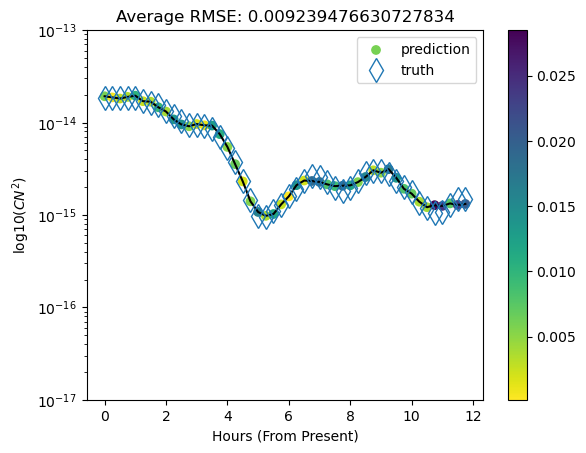

In [180]:
hrs = np.arange(output_len)

plt.scatter(hrs_2, ronso[:output_len] , c = error_gradient[:time_len], cmap='viridis_r', marker = 'o', label='prediction')
plt.plot(hrs_2, ronso[:output_len], color='black')
plt.plot(hrs_2, truth[:output_len], 'd', mfc='none', markersize=12, label='truth')
#plt.plot(hrs_2, truth[:output_len], color='blue')

plt.colorbar()
plt.ylabel(r'log10($CN^2$)')
plt.xlabel('Hours (From Present)')
plt.ylim(10**-17, 10**-13)
plt.yscale('log')
plt.title(f'Average RMSE: {np.mean(error_gradient)}')
plt.legend()

plt.savefig(f'Figure Plots/ex_{index}_{output_len}.pdf', format='pdf', bbox_inches='tight')


For smaller range forecasts, lets append multiple forecasts together and see how it looks

# Comparision Between Models

In [63]:
index = 48
X_test_pred = tf.expand_dims(X_test[index], axis=0)
ronso = loaded_model_1.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y_test[index]).flatten()

error_gradient =rms(truth[:time_len], ronso[:time_len])
hrs = np.arange(time_len-2)

# For plotting, unnormalize
ronso_2 = loaded_model_2.predict(X_test_pred, verbose=False)
ronso_2 = np.array(ronso_2[0]).flatten()
error_gradient_2 = rms(truth[:time_len], ronso_2[:time_len])

# Unnormalize

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))
ronso_2 = 10**(unnorm_data(ronso_2, minOut, maxOut))

# Make plots for both 

fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(hrs, truth[:time_len-2], marker = 'x')
im1 = ax[0].scatter(hrs, ronso[:time_len-2] , c = error_gradient[:10], cmap='viridis', marker = 'o')
ax[0].plot(hrs, ronso[:time_len-2], color='black')
cbar1 = plt.colorbar(im1, ax=ax[0])

ax[0].set_ylabel('log10(CN^2)')
ax[0].set_ylim(10**-17, 10**-13)
ax[0].set_yscale('log')
ax[0].set_title('With Bidirectional Layers')


ax[1].plot(hrs, truth[:time_len-2], marker = 'x')
im2 = ax[1].scatter(hrs, ronso_2[:time_len-2], c= error_gradient_2[:10])
ax[1].plot(hrs, ronso_2[:time_len-2], color='black')
cbar2 = plt.colorbar(im2, ax=ax[1])
ax[1].set_title('Without Bidirectional Layers')


ax[1].set_ylabel('log10(CN^2)')
ax[1].set_ylim(10**-17, 10**-13)
ax[1].set_yscale('log')


NameError: name 'loaded_model_2' is not defined

Let's compute an overall metric ... how about computing the RMSE over the entire testing dataset? 

In [50]:
RMSEs = []
#RMSEs_2 = []
#time_len_window = 4
#time_len_window_2 = 4
time_len_window = 360

for ii,x in enumerate(X_test):
    
    print(ii) 
    funky = tf.expand_dims(x, axis=0)
    
    preds = loaded_model_1.predict(funky, verbose=False)
    #preds_2 = loaded_model_2.predict(funky, verbose=False)
    
    truth = np.array(y_test[ii]).flatten()
    
    preds = np.array(preds[0]).flatten()
    #preds_2 = np.array(preds_2[0]).flatten()
    
    rmse = rms(truth[:output_len], preds[:output_len])
    #rmse_2 = rms(truth[:time_len_window_2], preds_2[:time_len_window_2])
    
    RMSEs.append(rmse)
    #RMSEs_2.append(rmse_2)
    print(np.mean(RMSEs))  
    if (ii>1000):
        print("finished")
        break; 

        
print(np.mean(RMSEs))   
#print(np.mean(RMSEs_2))

0
0.008945952860001194
1
0.008754282123801459
2
0.007794031850363546
3
0.0075189936805876755
4
0.008114824085039902
5
0.008210104569562941
6
0.008380781274030793
7
0.008326582112705918
8
0.00808182426946428
9
0.008051308116509054
10
0.00792945170436993
11
0.008304372912979637
12
0.008397085068694953
13
0.008342771948762647
14
0.008284875869945633
15
0.008663585327396037
16
0.009069951108368833
17
0.009245095789847932
18
0.009060306344483975
19
0.009041321662519908
20
0.008953341135000579
21
0.008967542164177047
22
0.008804582386013414
23
0.008728235589374652
24
0.00882755172720295
25
0.0089260430062767
26
0.008931742552735805
27
0.008763745755261862
28
0.009159763906226706
29
0.009099170161186517
30
0.00895674053992331
31
0.009017422108265215
32
0.00899053226673933
33
0.008936072449314724
34
0.008998961644042899
35
0.009066839072774118
36
0.009096085262578692
37
0.00912335681317759
38
0.00915419014764993
39
0.009083706729926129
40
0.008977092508876463
41
0.008912537943367285
42
0.00890

0.00848344717201405
336
0.008478175853946567
337
0.00847640779109158
338
0.00846870780076206
339
0.00846118364451118
340
0.008469534867834416
341
0.008479171446911087
342
0.008474072783521507
343
0.008473076287964294
344
0.008479120372165217
345
0.008479469615705384
346
0.008477168508209173
347
0.008469669028398874
348
0.008464844603680082
349
0.00846406872745749
350
0.008461874857671964
351
0.008455646924280013
352
0.008454357275912372
353
0.008455128158996017
354
0.008464608630331532
355
0.008457731951854655
356
0.008456386214945004
357
0.008445917542845212
358
0.008438450657319808
359
0.008436739112937172
360
0.008435919835828547
361
0.008445422503239588
362
0.008441549838399655
363
0.008440641016332013
364
0.008442810440341415
365
0.008446343754928632
366
0.008459092510618247
367
0.00845508969472387
368
0.008461622459369395
369
0.008457342816209542
370
0.008460274486557158
371
0.008460378746150982
372
0.00846134322822378
373
0.008459372606190719
374
0.00845214297659648
375
0.008466

0.008335051287056406
667
0.008329801422539328
668
0.008329477063484539
669
0.008328851662834388
670
0.00832727567523666
671
0.008326972339461678
672
0.00832612745755746
673
0.00832606914532852
674
0.00833590521352421
675
0.008337518828030459
676
0.00833340381306161
677
0.00832945229873541
678
0.008328247168956113
679
0.008327070400263268
680
0.008325859365830768
681
0.008328109237899027
682
0.008327190894746097
683
0.008329128881559976
684
0.008326167315918677
685
0.008327442911908244
686
0.008327180264737024
687
0.008324009209371803
688
0.008325863943889308
689
0.00833809224413737
690
0.008335981630740643
691
0.008342801361068863
692
0.008341537174171184
693
0.008342474138248077
694
0.008341561366024746
695
0.008342089053364633
696
0.008337586008864844
697
0.008341938117655934
698
0.0083396321048084
699
0.008343563917359183
700
0.008357754434368857
701
0.00835874780223235
702
0.008366458366802694
703
0.008362731677765366
704
0.008365181481314625
705
0.008362644195831093
706
0.00836084

0.008492168902709627
998
0.008492966194518859
999
0.008496503803316194
1000
0.008498134638523055
1001
0.008497776135175227
finished
0.008497776135175227


In [188]:
np.shape(RMSEs-_2)

NameError: name '_2' is not defined

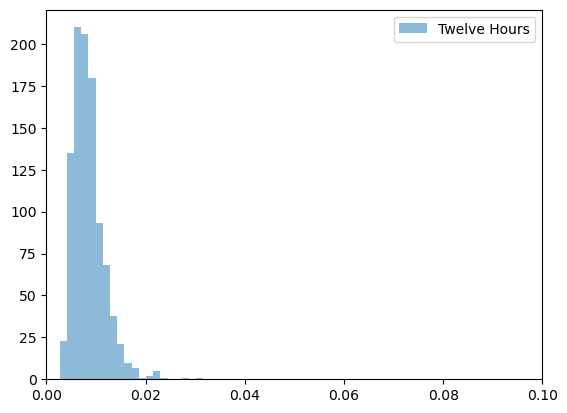

In [52]:
plt.hist(np.mean(RMSEs, axis=1), bins=20, label='Twelve Hours', alpha=0.5)
plt.xlim(0.0, 0.10)

#plt.hist(np.mean(RMSEs_2, axis=1), bins=80, label='Twelve Hours (Old Norm)', alpha=0.5)
plt.legend()

In [191]:
import heapq

def minN(lst, n=10):
    # Enumerate the list to pair each element with its index
    enumerated_lst = list(enumerate(lst))
    
    # Use heapq.nsmallest with a key function to sort by the list values
    smallest_elements_with_indices = heapq.nsmallest(n, enumerated_lst, key=lambda x: x[1])
    
    # Extract the indices and values separately if needed
    indices, values = zip(*smallest_elements_with_indices)
    
    return list(indices), list(values)


# same thing, but for n largest
def maxN(lst, n=10):
    # Enumerate the list to pair each element with its index
    enumerated_lst = list(enumerate(lst))
    
    # Use heapq.nlargest with a key function to sort by the list values
    largest_elements_with_indices = heapq.nlargest(n, enumerated_lst, key=lambda x: x[1])
    
    # Extract the indices and values separately if needed
    indices, values = zip(*largest_elements_with_indices)
    
    return list(indices), list(values)

mean_RMSEs = np.mean(RMSEs, axis=1)

In [193]:
total_indices = np.arange(len(mean_RMSEs))
max_indices,_ = maxN(mean_RMSEs, n=300)
min_indices,_ = minN(mean_RMSEs, n=300)


total_minus_max = np.setdiff1d(total_indices, max_indices)
central_indices = np.setdiff1d(total_minus_max, min_indices)


central_indices.sort()
max_indices.sort()
min_indices.sort()
    

In [194]:
min_indices

[40,
 42,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 66,
 68,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 171,
 172,
 173,
 174,
 175,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 329,
 330,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 360,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 584,
 58

# DEPRECIATED

Plotting Test RMSE vs. Forecast Length 

Text(0.5, 0, 'Forecast Series Length')

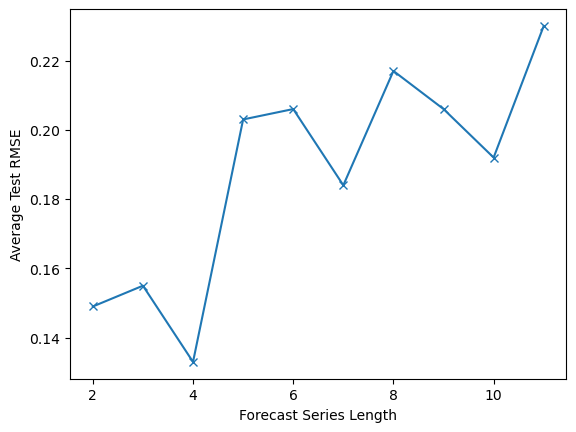

In [69]:
RMSEs_forecast = [0.149, 0.155, 0.133, 0.203, 0.206, 0.184, 0.217, 0.206, 0.192, 0.23]
timeLens = np.arange(2,12)
plt.plot(timeLens, RMSEs_forecast, marker = 'x')
plt.ylabel('Average Test RMSE')
plt.xlabel('Forecast Series Length')

Static Predictions

Plot model prediction vs. ground truths

In [64]:
model_predictions = []

for ii,x in enumerate(X_roll_test):
    print(ii)
    funky = tf.expand_dims(x, axis=0)
    preds = loaded_model.predict(funky, verbose=False)
    model_predictions.append(preds)
    
model_predictions = np.array(model_predictions)
Cn2_pred = model_predictions[:,0,0]
#r0_pred = model_predictions[:,0,1]

Cn2_true = y_test[:,0,0]
#r0_true = y_test[:,0,1]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Results on training data
Slope:1.113320864494608, intercept:-0.021167209522354943, r_value:0.8036351205908453


Text(0.5, 1.0, 'Ground Truths vs. Model Predictions -- $CN^2$\nR2 Value: 0.8036351205908453 -- Slope of Best Fit: 1.113320864494608')

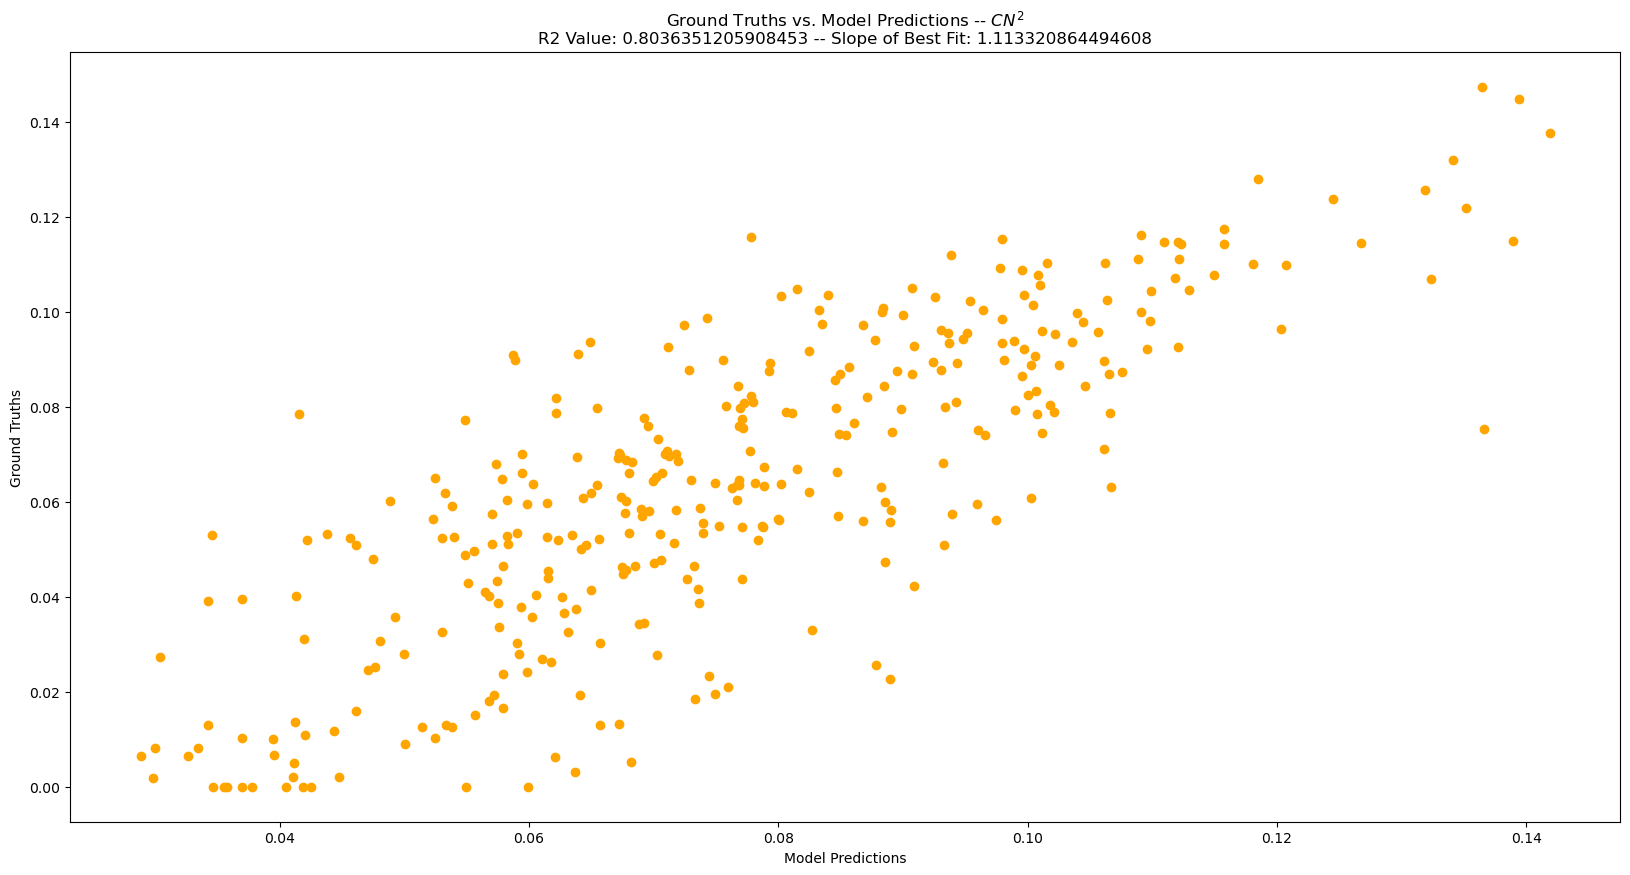

In [65]:
# Compute R2 value

slope_cn, intercept_cn, r_value_cn, p_value_cn, std_err_cn = stats.linregress(Cn2_pred, Cn2_true)

print("Results on training data")
print(f"Slope:{slope_cn}, intercept:{intercept_cn}, r_value:{r_value_cn}")

#slope_r0, intercept_r0, r_value_r0, p_value_r0, std_err_r0 = stats.linregress(r0_pred, r0_true)

#print("Results on training data")
#print(f"Slope:{slope_r0}, intercept:{intercept_r0}, r_value:{r_value_r0}")

fig, ax = plt.subplots(1,1, figsize=(20,10))


ax.scatter(Cn2_pred, Cn2_true, color='orange')
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Ground Truths')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title(f'Ground Truths vs. Model Predictions -- $CN^{2}$\nR2 Value: {r_value_cn} -- Slope of Best Fit: {slope_cn}')



#plt.savefig(f'R2Plots/{model_direc}.png', bbox_inches='tight')

# Plot Params 

ValueError: x and y must have same first dimension, but have shapes (10,) and (1080,)

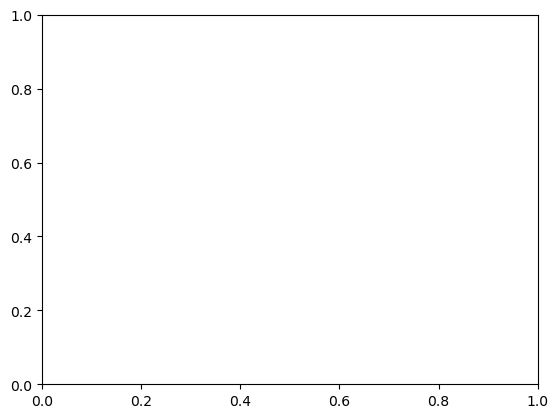

In [174]:
hrs = np.arange(10)

index = 20

plt.plot(hrs, X_train[index,:,0], label='solar_radiation')
plt.plot(hrs, X_train[index,:,1], label='relative_humidity')
plt.plot(hrs, X_train[index,:,2], label='CN2')
plt.plot(hrs, X_train[index,:,3], label='Temperature')
plt.legend()
plt.show()

Augment the dataset

ValueError: x and y must have same first dimension, but have shapes (10,) and (720,)

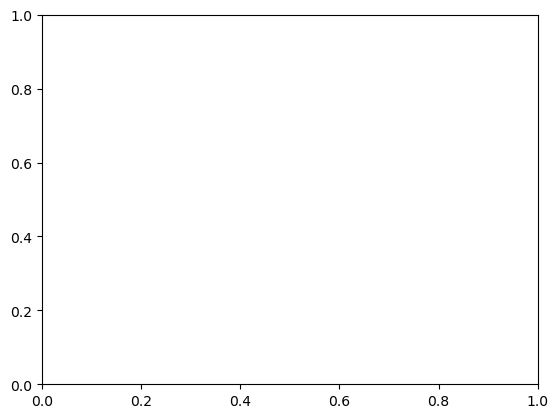

In [68]:
X_aug = window_warp(X_train)
hrs = np.arange(10)


index = 9

plt.plot(hrs, X_aug[index,:,0], label='solar_radiation')
plt.plot(hrs, X_aug[index,:,1], label='relative_humidity')
plt.plot(hrs, X_aug[index,:,2], label='CN2')
plt.plot(hrs, X_aug[index,:,3], label='Temperature')
plt.legend()
plt.show()


# Plot the Distribution of CN2 values

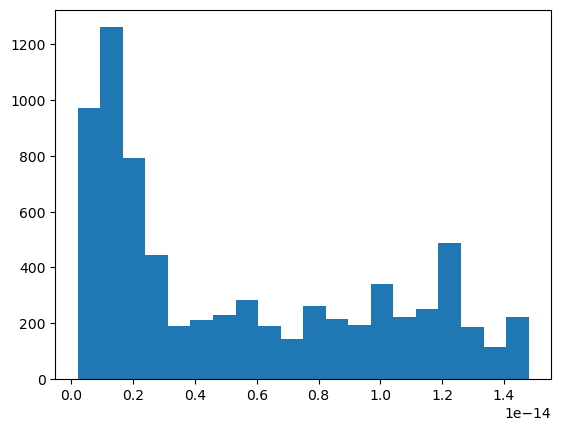

In [69]:
cn2_hist_train = 10**(unnorm_data(y_train.flatten(), minOut, maxOut))
cn2_hist_test = 10**(unnorm_data(y_test.flatten(), minOut, maxOut))

cn2_hist_max = np.array([np.max(datapt) for datapt in cn2_hist_train])
cn2_hist_min = np.array([np.min(datapt) for datapt in cn2_hist_train])

hist, bins,_ = plt.hist(cn2_hist_min, bins=20)

To give a sense of any possible bias within the training dataset, make a histogram of $CN^{2}$ values

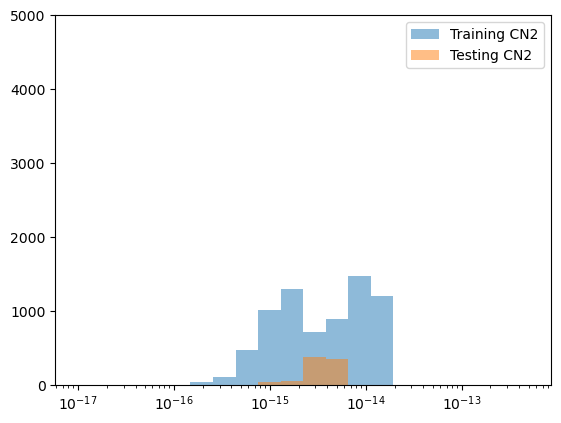

In [70]:
logbins = np.logspace(np.log10(1e-17),np.log10(5e-13), len(bins))

plt.hist(cn2_hist_train, bins=logbins, label = 'Training CN2', alpha=0.5)
plt.hist(cn2_hist_test, bins=logbins, label = 'Testing CN2', alpha=0.5)
plt.xscale('log')
plt.ylim(0,5000)
plt.legend()